<a href="https://colab.research.google.com/github/tatiana-iazykova/2020_HACK_RUSSIANSUPERGLUE/blob/main/RSG_LiDiRus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
%%capture
%%bash
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/ru/tasks/download/LiDiRus" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip
rm -r data/__MACOSX
rm -r sample_data/

# AX-b original English diagnostic dataset
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://dl.fbaipublicfiles.com/glue/superglue/data/v2/AX-b.zip" -O temp.zip
unzip temp.zip -d data

# remove unnecessary directories and files
rm temp.zip

# RSG TERRA dataset -> only to reproduce TfIdf baseline
# change url if you want to work with a different RSG dataset
wget -q --show-progress "https://russiansuperglue.com/tasks/download/TERRa" -O temp.zip
unzip temp.zip -d data
rm -r data/__MACOSX

# remove unnecessary directories and files
rm temp.zip

In [2]:
# Load necessary code files and models from https://github.com/RussianNLP/RussianSuperGLUE 
# to recreate TfIdf baseline

%%capture
%%bash
# load tfidf pickle created by RSG team
wget -q --show-progress "https://russiansuperglue.com/tasks/tf_idf" -O temp.zip
unzip temp.zip -d data
rm temp.zip

# Make sure you donwload with the raw file link
# Keep the link relevant to your dataset
wget -q --show-progress "https://github.com/RussianNLP/RussianSuperGLUE/raw/master/tfidf_baseline/LiDiRus.py" -O LiDiRus.py

In [3]:
%%capture
%%bash
# add tree package for fancy directory display
apt-get install tree

In [4]:
# display the content of the folder
!tree

.
├── data
│   ├── AX-b
│   │   └── AX-b.jsonl
│   ├── LiDiRus
│   │   └── LiDiRus.jsonl
│   ├── TERRa
│   │   ├── test.jsonl
│   │   ├── train.jsonl
│   │   └── val.jsonl
│   └── tfidf.pkl
└── LiDiRus.py

4 directories, 7 files


### **Start playing here**

In [5]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 80)

class JSONL_handler():
    """ opens a jsonl file and turns it into a necessary data structure """
    
    def __init__(self, path):
        self.path = path # path to jsonl file

    def to_pandas(self):
        """ get jsonl file content as a pandas DataFrame"""
        return pd.read_json(path_or_buf=self.path, lines=True)

In [6]:
handler = JSONL_handler('data/LiDiRus/LiDiRus.jsonl')
df = handler.to_pandas()
handler_en = JSONL_handler('data/AX-b/AX-b.jsonl')
df_en = handler.to_pandas()

### Explore Ru and Eng dataset

Russian is a manual translation of an English diagnistic dataset
https://russiansuperglue.com/tasks/task_info/LiDiRus

In [7]:
import matplotlib.pyplot as plt

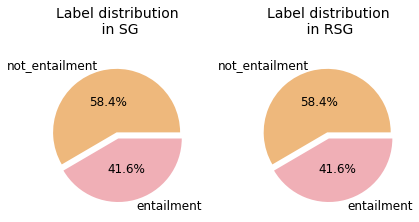

In [8]:
plt.subplot(1,2,1)
colours = {'#9ddca6', '#f0afb6', '#eeb87c'}

plt.title('Label distribution\n in SG\n', fontsize=14)
plt.pie(df_en['label'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=df_en['label'].value_counts().keys(), pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.subplot(1,2,2)

plt.title('Label distribution\n in RSG\n', fontsize=14)
plt.pie(df['label'].value_counts(), autopct="%.1f%%", explode=[0.05]*2, labels=df['label'].value_counts().keys(), pctdistance=0.5, textprops = dict(fontsize = 12), colors=colours)

plt.tight_layout()
plt.show()

# Reproduce TfIdf baseline

In [9]:
import pickle
import codecs
import joblib
import LiDiRus

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

vect = joblib.load("data/tfidf.pkl")

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
# Note that train and val datasets are not from LiDiRus as it is a diagnostics dataset
train_path = "data/TERRa/train.jsonl"
val_path = "data/TERRa/val.jsonl"
test_path = "data/LiDiRus/LiDiRus.jsonl"

_, LiDiRus_scores = LiDiRus.eval_LiDiRus(train_path, val_path, test_path, vect)
LiDiRus_scores["train"], LiDiRus_scores["test"]

(0.4294719661883857, 0.05974021843803689)

# Explore LiDiRus Dataset

In [ ]:
pd.merge(df.logic.value_counts(), df_en.logic.value_counts(), how='left', on=df_en.logic.value_counts().keys())

,key_0,logic_x,logic_y
0,Negation,54,54
1,Upward monotone,30,30
2,Intervals/Numbers,30,30
3,Temporal,28,28
4,Downward monotone,26,26
5,Double negation,26,26
6,Conjunction,24,24
7,Non-monotone,22,22
8,Conditionals,22,22
9,Disjunction,22,22


In [ ]:
df.columns

Index(['idx', 'label', 'sentence1', 'sentence2', 'logic',
       'predicate-argument-structure', 'lexical-semantics', 'knowledge'],
      dtype='object')

In [ ]:
df['knowledge'].value_counts()

Common sense       150
World knowledge    134
Name: knowledge, dtype: int64

In [ ]:
df['predicate-argument-structure'].value_counts()

Prepositional phrases                         56
Core args                                     48
Intersectivity                                44
Anaphora/Coreference                          42
Coordination scope                            34
Active/Passive                                32
Ellipsis/Implicits                            28
Nominalization                                26
Relative clauses                              24
Datives                                       20
Genitives/Partitives                          18
Restrictivity                                 18
Coordination scope;Prepositional phrases       6
Relative clauses;Restrictivity                 4
Core args;Anaphora/Coreference                 4
Anaphora/Coreference;Prepositional phrases     4
Ellipsis/Implicits;Anaphora/Coreference        4
Nominalization;Genitives/Partitives            2
Restrictivity;Anaphora/Coreference             2
Relative clauses;Anaphora/Coreference          2
Restrictivity;Relati

In [ ]:
df['lexical-semantics'].value_counts()

Lexical entailment                134
Factivity                          64
Quantifiers                        46
Named entities                     36
Symmetry/Collectivity              28
Morphological negation             26
Redundancy                         25
Lexical entailment;Quantifiers      4
Lexical entailment;Factivity        2
Factivity;Quantifiers               2
Name: lexical-semantics, dtype: int64

### There are small batches of sentences with slightly varying vocabulary

In [ ]:
df.iloc[[0,1,4,5,6,7]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
0,0,not_entailment,Кошка сидела на коврике.,Кошка не сидела на коврике.,Negation,NaN,NaN,NaN
1,1,not_entailment,Кошка не сидела на коврике.,Кошка сидела на коврике.,Negation,NaN,NaN,NaN
4,4,not_entailment,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.","Сразу же после распаковки Ouya не поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.",Negation,NaN,NaN,NaN
5,5,not_entailment,"Сразу же после распаковки Ouya не поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.","Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC-медиаплеер.",Negation,NaN,NaN,NaN
6,6,entailment,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,NaN,Anaphora/Coreference,NaN,NaN
7,7,entailment,Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",NaN,Anaphora/Coreference,NaN,NaN


# Intermediary conslusions

### Entailment indicators:
 - vocabulary overlap
 - double negation within one clause
 - if lemmantized, certain sentences will overlap in vocabulary

### Not-entailment indicators:
 - negation in one clause
 - variation in one word only (the phrase length is the same)



# Entailment

In [ ]:
df[df.label == 'entailment'][60:70]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
135,135,entailment,"Базы знаний содержат факты из неструктурированных текстовых корпусов, полученные от систем извлечения связей.",Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,NaN,Active/Passive,NaN,NaN
136,136,entailment,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,Базы знаний при участии систем извлечения связей заполняются фактами из неструктурированных текстовых корпусов.,NaN,Active/Passive,NaN,NaN
137,137,entailment,Базы знаний при участии систем извлечения связей заполняются фактами из неструктурированных текстовых корпусов.,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,NaN,Active/Passive,NaN,NaN
142,142,entailment,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,Системы извлечения связей заполняют базы знаний данными из неструктурированных текстовых корпусов.,NaN,NaN,Lexical entailment,World knowledge
143,143,entailment,Системы извлечения связей заполняют базы знаний данными из неструктурированных текстовых корпусов.,Системы извлечения связей заполняют базы знаний фактами из неструктурированных текстовых корпусов.,NaN,NaN,Lexical entailment,World knowledge
144,144,entailment,"Недавний шаг Walmart'а связан с постоянными усилиями компании отбросить назад таких конкурентов, как Amazon.","Недавний шаг компании Walmart связан с её постоянными усилиями отбросить назад таких конкурентов, как Amazon.",NaN,Genitives/Partitives,NaN,NaN
145,145,entailment,"Недавний шаг компании Walmart связан с её постоянными усилиями отбросить назад таких конкурентов, как Amazon.","Недавний шаг Walmart'а связан с постоянными усилиями компании отбросить назад таких конкурентов, как Amazon.",NaN,Genitives/Partitives,NaN,NaN
148,148,entailment,"Мужчина опускается на одно колено и осматривает ступню слона, только чтобы обнаружить, что большая заноза засела глубоко.","Мужчина опускается на одно колено и осматривает слоновью ступню, только чтобы обнаружить, что большая заноза засела глубоко.",NaN,Genitives/Partitives,NaN,NaN
149,149,entailment,"Мужчина опускается на одно колено и осматривает слоновью ступню, только чтобы обнаружить, что большая заноза засела глубоко.","Мужчина опускается на одно колено и осматривает ступню слона, только чтобы обнаружить, что большая заноза засела глубоко.",NaN,Genitives/Partitives,NaN,NaN
150,150,entailment,"Воробьиная популяция Южной Африки существенно не уменьшилась, и человеческая деятельность серьёзно ей не угрожает.","Популяция южноафриканских воробьёв существенно не уменьшилась, и человеческая деятельность серьёзно ей не угрожает.",NaN,Genitives/Partitives,NaN,NaN


### Vocabulary overlap

In [ ]:
df.iloc[[6,7,18,32,33,56,63,72,74,75,77,80,81,82,83,84,85,144,145]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
6,6,entailment,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,NaN,Anaphora/Coreference,NaN,NaN
7,7,entailment,Сразу же после распаковки Ouya поддерживает Twitch.tv и XBMC медиа-плеер.,"Сразу же после распаковки Ouya поддерживает мультимедийные приложения, такие как Twitch.tv и XBMC медиа-плеер.",NaN,Anaphora/Coreference,NaN,NaN
18,18,entailment,"Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию протеста, Ганди застал администрацию врасплох и получил уступки от властей.",NaN,Intersectivity,NaN,NaN
32,32,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна ожидаемо.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, ожидаемо негативное влияние на результаты пайплайна.",NaN,Nominalization,NaN,NaN
33,33,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, ожидаемо негативное влияние на результаты пайплайна.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна ожидаемо.",NaN,Nominalization,NaN,NaN
56,56,entailment,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим некоторые слова как положительные примеры – и несколько негативных наугад из словаря.,Upward monotone,Intersectivity,NaN,NaN
63,63,entailment,Рассмотрим все слова как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Downward monotone,Intersectivity,NaN,NaN
72,72,entailment,"На всех территориях деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.","На всех развитых территориях деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.",Downward monotone,Intersectivity,NaN,NaN
74,74,entailment,Том и Адам шептались в театре.,Том и Адам тихо шептались в театре.,NaN,NaN,Redundancy,NaN
75,75,entailment,Том и Адам тихо шептались в театре.,Том и Адам шептались в театре.,NaN,NaN,Redundancy,NaN


2 negatation words: "не", "никогда", etc.

In [ ]:
df.iloc[[24,25,26,27,28,29,30,31,34,35]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
24,24,entailment,"Рынок станет сложнее, но на нём не будет невозможно ориентироваться.","Рынок станет сложнее, но на нём будет возможно ориентироваться.",Double negation,NaN,Morphological negation,NaN
25,25,entailment,"Рынок станет сложнее, но на нём будет возможно ориентироваться.","Рынок станет сложнее, но на нём не будет невозможно ориентироваться.",Double negation,NaN,Morphological negation,NaN
26,26,entailment,"Даже после того как узнал, что это корм для животных, я не перестану когда-либо обожать Flamin' Hot Cheetos.","Даже после того как узнал, что это корм для животных, я никогда не перестану обожать Flamin' Hot Cheetos.",Double negation,NaN,Morphological negation,NaN
27,27,entailment,"Даже после того как узнал, что это корм для животных, я никогда не перестану обожать Flamin' Hot Cheetos.","Даже после того как узнал, что это корм для животных, я не перестану когда-либо обожать Flamin' Hot Cheetos.",Double negation,NaN,Morphological negation,NaN
28,28,entailment,"Он не был несогласен с позицией партии, но чувствовал, что если бы он ушел в отставку, его популярность среди индейцев перестала бы душить членство в партии.","Он согласился с позицией партии, но чувствовал, что если бы он ушел в отставку, его популярность среди индейцев перестала бы душить членство в партии.",Double negation,NaN,Morphological negation,NaN
29,29,entailment,"Он согласился с позицией партии, но чувствовал, что если бы он ушел в отставку, его популярность среди индейцев перестала бы душить членство в партии.","Он не был несогласен с позицией партии, но чувствовал, что если бы он ушел в отставку, его популярность среди индейцев перестала бы душить членство в партии.",Double negation,NaN,Morphological negation,NaN
30,30,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна должно быть ожидаемым.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна не должно быть неожиданным.",Double negation,NaN,Morphological negation,NaN
31,31,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна не должно быть неожиданным.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна должно быть ожидаемым.",Double negation,NaN,Morphological negation,NaN
34,34,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна должно быть ожидаемым.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, не должно быть неожиданным негативное влияние на результаты пайплайна.",Double negation,Nominalization,Morphological negation,NaN
35,35,entailment,"Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, не должно быть неожиданным негативное влияние на результаты пайплайна.","Если схема токенизации пайплайна не соответствует той, которая использовалась при создании модели, негативное влияние на результаты пайплайна должно быть ожидаемым.",Double negation,Nominalization,Morphological negation,NaN


###  other, including active/passive which will be close to overlapping after lemmantizing

In [ ]:
df.iloc[[22,23,44,45,48,51,52,54,61,65,66,78,79,86,87,90,91,94,95,108,109,142,143, 149, 150]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
22,22,entailment,Написание кода на Java не слишком отличается от программирования в наручниках.,Написание кода на Java подобно программированию в наручниках.,Double negation,NaN,Morphological negation,NaN
23,23,entailment,Написание кода на Java подобно программированию в наручниках.,Написание кода на Java не слишком отличается от программирования в наручниках.,Double negation,NaN,Morphological negation,NaN
44,44,entailment,"В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно легко увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN
45,45,entailment,"В примере (1) достаточно легко увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN
48,48,entailment,Некоторые собаки любят чесать свои уши.,Некоторые животные любят чесать свои уши.,Upward monotone,NaN,Lexical entailment,NaN
51,51,entailment,"Круз неоднократно высмеивал как ""амнистию"" различные законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" различные планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Upward monotone,NaN,NaN,World knowledge
52,52,entailment,"Большинство выпускников моей программы переключились на другие вещи, потому что работа отстой.","Некоторые из выпускников моей программы переключились на другие вещи, потому что работа отстой.",NaN,NaN,Quantifiers,NaN
54,54,entailment,"Во многих развитых районах деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.","Во многих областях деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.",Upward monotone,Intersectivity,NaN,NaN
61,61,entailment,Рассмотрим многие слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN
65,65,entailment,Все животные любят чесать свои уши.,Все собаки любят чесать свои уши.,Downward monotone,NaN,Lexical entailment,NaN


### Some questions on labels

In [ ]:
df.iloc[[132]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
132,132,entailment,"Южноафриканские воробьи охотно питаются семенами, мягкими частями растений и насекомыми.",Мягкие части растений и насекомые съедены.,NaN,Active/Passive;Prepositional phrases,NaN,NaN


# Not Entailment

In [ ]:
df[df.label == 'not_entailment'][30:40]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
50,50,not_entailment,"Круз неоднократно высмеивал как ""амнистию"" различные планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" различные законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Upward monotone,NaN,NaN,World knowledge
53,53,not_entailment,"Некоторые из выпускников моей программы переключились на другие вещи, потому что работа отстой.","Большинство выпускников моей программы переключились на другие вещи, потому что работа отстой.",NaN,NaN,Quantifiers,NaN
55,55,not_entailment,"Во многих областях деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.","Во многих развитых районах деятельность человека изменила форму русла рек, влияя на масштаб и частоту наводнений.",Upward monotone,Intersectivity,NaN,NaN
57,57,not_entailment,Рассмотрим некоторые слова как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Upward monotone,Intersectivity,NaN,NaN
58,58,not_entailment,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN
59,59,not_entailment,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN
60,60,not_entailment,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Мы рассматриваем многие контекстные слова как положительные примеры и образец негативы наугад из словаря.,NaN,NaN,Quantifiers,NaN
62,62,not_entailment,Рассмотрим все слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова как положительные примеры – и несколько негативных наугад из словаря.,Downward monotone,Intersectivity,NaN,NaN
64,64,not_entailment,Все собаки любят чесать свои уши.,Все животные любят чесать свои уши.,Downward monotone,NaN,Lexical entailment,NaN
67,67,not_entailment,"Круз неоднократно высмеивал как ""амнистию"" любые законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" любые планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Downward monotone,NaN,NaN,World knowledge


### +1 negation word

In [ ]:
df.iloc[[0,1,2,3,16,17,542,543,544,545]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
0,0,not_entailment,Кошка сидела на коврике.,Кошка не сидела на коврике.,Negation,NaN,NaN,NaN
1,1,not_entailment,Кошка не сидела на коврике.,Кошка сидела на коврике.,Negation,NaN,NaN,NaN
2,2,not_entailment,"Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.","Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.",Negation,NaN,NaN,NaN
3,3,not_entailment,"Когда у вас есть снег, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.","Когда у вас нет снега, очень сложно обучиться зимним видам спорта, так что мы искали все способы изучить без снега то, что я мог бы потом повторить на снегу.",Negation,NaN,NaN,NaN
16,16,not_entailment,"Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию насильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.",Negation,NaN,Morphological negation,NaN
17,17,not_entailment,"Применяя стратегию насильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.","Применяя стратегию ненасильственного протеста, Ганди застал администрацию врасплох и получил уступки от властей.",Negation,NaN,Morphological negation,NaN
542,542,not_entailment,"Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.","Корпорация Microsoft считает иск обоснованным, потому что обнаружена единая причина для жалоб работников и истцы не выявили системной дискриминации по признаку пола.",Double negation,NaN,NaN,NaN
543,543,not_entailment,"Корпорация Microsoft считает иск обоснованным, потому что обнаружена единая причина для жалоб работников и истцы не выявили системной дискриминации по признаку пола.","Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.",Double negation,NaN,NaN,NaN
544,544,not_entailment,"Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.","Корпорация Microsoft считает иск обоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.",Negation,NaN,NaN,NaN
545,545,not_entailment,"Корпорация Microsoft считает иск обоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.","Корпорация Microsoft считает иск необоснованным, потому что нет единой причиной для жалоб работников и истцы не выявили системной дискриминации по признаку пола.",Negation,NaN,NaN,NaN


### Different in one key word

In [ ]:
df.iloc[[36,37,42,43, 58, 59]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
36,36,not_entailment,Вода слишком горячая.,Вода слишком холодная.,NaN,NaN,Lexical entailment,NaN
37,37,not_entailment,Вода слишком холодная.,Вода слишком горячая.,NaN,NaN,Lexical entailment,NaN
42,42,not_entailment,"В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно сложно увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN
43,43,not_entailment,"В примере (1) достаточно сложно увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.","В примере (1) достаточно просто увидеть преувеличенный позитивный настрой, используемый для того, чтобы передать сильные негативные чувства.",NaN,NaN,Lexical entailment,NaN
58,58,not_entailment,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN
59,59,not_entailment,Рассмотрим все слова из контекста как положительные примеры – и много негативных наугад из словаря.,Рассмотрим некоторые слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,NaN,NaN,Quantifiers,NaN


# Examples to note and discuss

In [ ]:
df.iloc[[48,49,62,50,51,66,67]]

,idx,label,sentence1,sentence2,logic,predicate-argument-structure,lexical-semantics,knowledge
48,48,entailment,Некоторые собаки любят чесать свои уши.,Некоторые животные любят чесать свои уши.,Upward monotone,NaN,Lexical entailment,NaN
49,49,not_entailment,Некоторые животные любят чесать свои уши.,Некоторые собаки любят чесать свои уши.,Upward monotone,NaN,Lexical entailment,NaN
62,62,not_entailment,Рассмотрим все слова из контекста как положительные примеры – и несколько негативных наугад из словаря.,Рассмотрим все слова как положительные примеры – и несколько негативных наугад из словаря.,Downward monotone,Intersectivity,NaN,NaN
50,50,not_entailment,"Круз неоднократно высмеивал как ""амнистию"" различные планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" различные законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Upward monotone,NaN,NaN,World knowledge
51,51,entailment,"Круз неоднократно высмеивал как ""амнистию"" различные законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" различные планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Upward monotone,NaN,NaN,World knowledge
66,66,entailment,"Круз неоднократно высмеивал как ""амнистию"" любые планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" любые законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Downward monotone,NaN,NaN,World knowledge
67,67,not_entailment,"Круз неоднократно высмеивал как ""амнистию"" любые законопроекты, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.","Круз неоднократно высмеивал как ""амнистию"" любые планы, призванные дать правовой статус или гражданство людям, живущим в стране незаконно.",Downward monotone,NaN,NaN,World knowledge
